In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook determines an e-distance for each perturbation relative to control cells to (relatively) quantify their magnitude ###

import h5py
import numpy as np
import pandas as pd
import nexusformat.nexus as nx
import tables
import scipy
import scanpy as sc
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as pl
import math
%load_ext rpy2.ipython

# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.2.2 
2: package ‘datasets’ was built under R version 4.2.2 
3: package ‘utils’ was built under R version 4.2.2 
4: package ‘grDevices’ was built under R version 4.2.2 
5: package ‘graphics’ was built under R version 4.2.2 
6: package ‘stats’ was built under R version 4.2.2 


In [2]:
### things to vary to get better p-values and non-negative distances

## the control guide which things are assessed relative to (spend time picking good controls)
## assess # of control cells vs pertuabtion cells and vary the number of sampled cells in class imbalance
## look how big the radius of perturbation and control is in PC space and cutoff # of PCs used in dist calculation
## lower max variable features during to 500?


In [3]:
## Load in data ##
adata = sc.read('/home/ssobti/projects/mir_tud/010523_filtered_data/miR.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.h5ad')

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


In [4]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   
...                             ...         ...           ...    ...   
miR_3:TTTGGTTTCGGACTTA-1        miR     25937.0          5525  miR_3   
miR_3:TTTGTTGCACGCGTGT-1        miR     82115.0          8826  miR_3   
miR_3:TTTGTTGCATAGATCC-1        miR     34833.0          6430  miR_3   
miR_3:TTTGTTGGTCTAGTGT-1        miR     22318.0          5103  miR_3   
miR_3:TTTGTTGGTTTCCATT-1        miR     19834.0          5082  miR_3   

                                   barcode             guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC   hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT     hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT   hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA         TuD_NC_18  5.859895   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT   hsa-miR-147b-5p  5.632808   
...                                    ...               ...       ...   
miR_3:TTTGGTTTCGGACTTA-1  TTTGGTTTCGGACTTA    hsa-miR-616-5p  3.885564   
miR_3:TTTGTTGCACGCGTGT-1  TTTGTTGCACGCGTGT    hsa-miR-361-5p  0.506602   
miR_3:TTTGTTGCATAGATCC-1  TTTGTTGCATAGATCC   hsa-miR-548o-3p  6.603449   
miR_3:TTTGTTGGTCTAGTGT-1  TTTGTTGGTCTAGTGT   hsa-miR-3940-5p  2.402414   
miR_3:TTTGTTGGTTTCCATT-1  TTTGTTGGTTTCCATT  hsa-miR-10527-5p  6.014592   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0  ...   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  ...   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  ...   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  ...   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0  ...   
...                                 ...            ...      ...  ...   
miR_3:TTTGGTTTCGGACTTA-1  8.005527e-277  6.410418e-270    129.0  ...   
miR_3:TTTGTTGCACGCGTGT-1   8.834341e-07   1.000000e+00      2.0  ...   
miR_3:TTTGTTGCATAGATCC-1  5.795787e-306  4.640971e-299    126.0  ...   
miR_3:TTTGTTGGTCTAGTGT-1  5.349572e-125  4.283664e-118     58.0  ...   
miR_3:TTTGTTGGTTTCCATT-1  4.169835e-209  3.338991e-202    101.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   
...                            ...        ...          ...        ...   
miR_3:TTTGGTTTCGGACTTA-1  0.596977  44.983627     2.110590   2.374748   
miR_3:TTTGTTGCACGCGTGT-1  0.030227   0.034438     0.301030   1.079181   
miR_3:TTTGTTGCATAGATCC-1  0.400504  40.028586     2.100371   2.201397   
miR_3:TTTGTTGGTCTAGTGT-1  0.277078   9.251317     1.763428   2.041393   
miR_3:TTTGTTGGTTTCCATT-1  0.329975  25.736801     2.004321   2.117271   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   
...                             ...         ...                     ...   
miR_

In [5]:
#meta data prior to filtering
meta = adata.obs
meta['guide'] = meta['guide'].astype('string')
meta.loc[meta.loc[:,'guide'].str.startswith('TuD'), 'guide'] = 'TuD_NC'
meta['guide'] = meta['guide'].astype('category')
meta.dtypes

orig.ident                  object
nCount_RNA                 float64
nFeature_RNA                 int32
sample                      object
barcode                     object
guide                     category
lor                        float64
pvalue                     float64
adj_pvalue                 float64
max_umi                    float64
n_umi                      float64
m_umi                      float64
v_umi                      float64
log_max_umi                float64
log_n_umi                  float64
log_m_umi                  float64
percent.mt                 float64
integrated_snn_res.0.5       int32
seurat_clusters             object
guide_group                 object
miR.family                  object
dtype: object

In [6]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   
...                             ...         ...           ...    ...   
miR_3:TTTGGTTTCGGACTTA-1        miR     25937.0          5525  miR_3   
miR_3:TTTGTTGCACGCGTGT-1        miR     82115.0          8826  miR_3   
miR_3:TTTGTTGCATAGATCC-1        miR     34833.0          6430  miR_3   
miR_3:TTTGTTGGTCTAGTGT-1        miR     22318.0          5103  miR_3   
miR_3:TTTGTTGGTTTCCATT-1        miR     19834.0          5082  miR_3   

                                   barcode             guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC   hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT     hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT   hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA            TuD_NC  5.859895   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT   hsa-miR-147b-5p  5.632808   
...                                    ...               ...       ...   
miR_3:TTTGGTTTCGGACTTA-1  TTTGGTTTCGGACTTA    hsa-miR-616-5p  3.885564   
miR_3:TTTGTTGCACGCGTGT-1  TTTGTTGCACGCGTGT    hsa-miR-361-5p  0.506602   
miR_3:TTTGTTGCATAGATCC-1  TTTGTTGCATAGATCC   hsa-miR-548o-3p  6.603449   
miR_3:TTTGTTGGTCTAGTGT-1  TTTGTTGGTCTAGTGT   hsa-miR-3940-5p  2.402414   
miR_3:TTTGTTGGTTTCCATT-1  TTTGTTGGTTTCCATT  hsa-miR-10527-5p  6.014592   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0  ...   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  ...   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  ...   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  ...   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0  ...   
...                                 ...            ...      ...  ...   
miR_3:TTTGGTTTCGGACTTA-1  8.005527e-277  6.410418e-270    129.0  ...   
miR_3:TTTGTTGCACGCGTGT-1   8.834341e-07   1.000000e+00      2.0  ...   
miR_3:TTTGTTGCATAGATCC-1  5.795787e-306  4.640971e-299    126.0  ...   
miR_3:TTTGTTGGTCTAGTGT-1  5.349572e-125  4.283664e-118     58.0  ...   
miR_3:TTTGTTGGTTTCCATT-1  4.169835e-209  3.338991e-202    101.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   
...                            ...        ...          ...        ...   
miR_3:TTTGGTTTCGGACTTA-1  0.596977  44.983627     2.110590   2.374748   
miR_3:TTTGTTGCACGCGTGT-1  0.030227   0.034438     0.301030   1.079181   
miR_3:TTTGTTGCATAGATCC-1  0.400504  40.028586     2.100371   2.201397   
miR_3:TTTGTTGGTCTAGTGT-1  0.277078   9.251317     1.763428   2.041393   
miR_3:TTTGTTGGTTTCCATT-1  0.329975  25.736801     2.004321   2.117271   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   
...                             ...         ...                     ...   
miR_

In [7]:
count_df = meta.groupby(by = ['guide']).size().reset_index(name = 'cells')
idxs = count_df.loc[:,'guide'].str.startswith('TuD')
guide_type = ['control' if x is True else 'perturbation' for x in idxs]
count_df['type'] = guide_type
count_df

guide  cells          type
0             TuD_NC   3101       control
1    hsa-let-7a-2-3p     59  perturbation
2      hsa-let-7a-5p      9  perturbation
3      hsa-let-7b-3p     86  perturbation
4      hsa-let-7d-3p     49  perturbation
..               ...    ...           ...
373    hsa-miR-96-5p     72  perturbation
374    hsa-miR-98-3p     81  perturbation
375     hsa-miR-9903     78  perturbation
376   hsa-miR-99b-3p     71  perturbation
377   hsa-miR-99b-5p     74  perturbation

[378 rows x 3 columns]

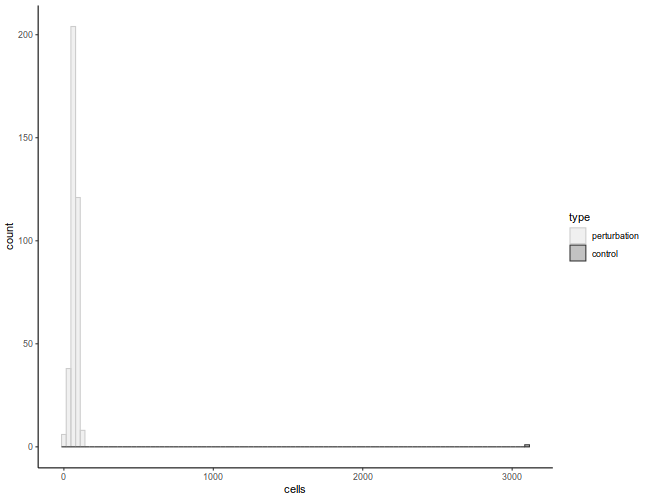

In [8]:
%%R -i count_df -w 650 -h 500
### data exploration of cells per perturbation with histogram

library(ggplot2)
count_df2 = count_df[!count_df$guide == 'TuD_NC_01',]
count_df2$type <- factor(count_df2$type, levels = c('perturbation', 'control'))

## without TuD_NC_01 which has 1687 cells
ggplot(count_df2, aes(x = cells, fill = type, color = type)) + 
geom_histogram(position = "identity", alpha = 0.3, bins = 100) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) + theme_classic()

In [9]:
adata.obs = meta
adata.obs.head()

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   

                                   barcode            guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC  hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT    hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT  hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA           TuD_NC  5.859895   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT  hsa-miR-147b-5p  5.632808   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0  ...   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  ...   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  ...   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  ...   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   

                          seurat_clusters guide_group  \
miR_1:AAACCCAAGGAGAGGC-1               T2      target   
miR_1:AAACCCAAGGTAAACT-1               T0      target   
miR_1:AAACCCACAACGATCT-1               T0      target   
miR_1:AAACCCACACGATTCA-1          control     control   
miR_1:AAACCCACAGTCAACT-1               T8      target   

                                        miR.family  
miR_1:AAACCCAAGGAGAGGC-1             miR-203a-3p.1  
miR_1:AAACCCAAGGTAAACT-1                 miR-93-3p  
miR_1:AAACCCACAACGATCT-1  miR-130-3p/301-3p/454-3p  
miR_1:AAACCCACACGATTCA-1                        NA  
miR_1:AAACCCACAGTCAACT-1                  miR-147b  

[5 rows x 21 columns]

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


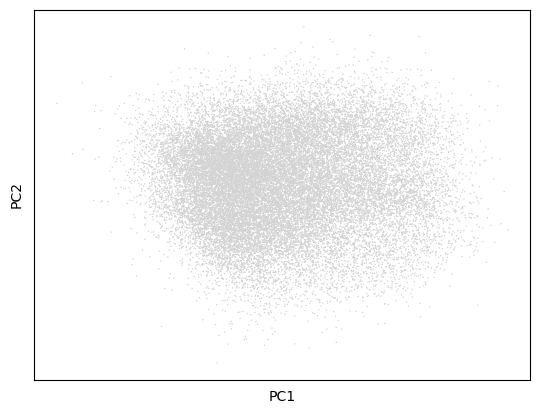

In [10]:
sc.pl.pca(adata)

In [11]:
# high class imbalance
adata = equal_subsampling(adata, 'guide', N_min=50)

In [12]:
adata.uns['processed'] = True

In [13]:
#meta data post-filtering
meta = adata.obs
meta

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_2:TTCCGGTCAAGTGCAG-1        miR     30561.0          6252  miR_2   
miR_2:AAGCATCAGGAGAGGC-1        miR     26040.0          5676  miR_2   
miR_3:CCTTCAGCAAGTTCCA-1        miR     48031.0          7710  miR_3   
miR_2:TCACTATTCAATCAGC-1        miR     12131.0          3903  miR_2   
miR_1:TCACTCGCAAATACAG-1        miR     55856.0          7939  miR_1   
...                             ...         ...           ...    ...   
miR_3:ATACCTTGTAACAGTA-1        miR    103604.0          9812  miR_3   
miR_1:GCAACATGTAGTACGG-1        miR     55806.0          7906  miR_1   
miR_1:TCTTCCTAGACGGATC-1        miR     63381.0          8617  miR_1   
miR_1:GAAGTAACAAATGGAT-1        miR     32204.0          6274  miR_1   
miR_1:TGATCAGCACTGGCGT-1        miR     33970.0          5978  miR_1   

                                   barcode            guide       lor  \
miR_2:TTCCGGTCAAGTGCAG-1  TTCCGGTCAAGTGCAG           TuD_NC  3.894979   
miR_2:AAGCATCAGGAGAGGC-1  AAGCATCAGGAGAGGC           TuD_NC  5.145884   
miR_3:CCTTCAGCAAGTTCCA-1  CCTTCAGCAAGTTCCA           TuD_NC  0.771760   
miR_2:TCACTATTCAATCAGC-1  TCACTATTCAATCAGC           TuD_NC  0.987241   
miR_1:TCACTCGCAAATACAG-1  TCACTCGCAAATACAG           TuD_NC  2.706123   
...                                    ...              ...       ...   
miR_3:ATACCTTGTAACAGTA-1  ATACCTTGTAACAGTA  hsa-miR-301a-5p  2.527127   
miR_1:GCAACATGTAGTACGG-1  GCAACATGTAGTACGG  hsa-miR-301a-5p  2.933985   
miR_1:TCTTCCTAGACGGATC-1  TCTTCCTAGACGGATC  hsa-miR-301a-5p  6.478721   
miR_1:GAAGTAACAAATGGAT-1  GAAGTAACAAATGGAT  hsa-miR-301a-5p  6.377584   
miR_1:TGATCAGCACTGGCGT-1  TGATCAGCACTGGCGT  hsa-miR-301a-5p  1.830565   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_2:TTCCGGTCAAGTGCAG-1   1.444912e-45   1.503828e-38     43.0  ...   
miR_2:AAGCATCAGGAGAGGC-1  2.810142e-190  2.924727e-183     85.0  ...   
miR_3:CCTTCAGCAAGTTCCA-1   8.954815e-79   7.170559e-72     49.0  ...   
miR_2:TCACTATTCAATCAGC-1   4.426048e-29   4.606521e-22     26.0  ...   
miR_1:TCACTCGCAAATACAG-1   6.059599e-31   6.115671e-24     16.0  ...   
...                                 ...            ...      ...  ...   
miR_3:ATACCTTGTAACAGTA-1  4.940656e-324  3.956226e-317    253.0  ...   
miR_1:GCAACATGTAGTACGG-1  6.438111e-111  6.497685e-104     48.0  ...   
miR_1:TCTTCCTAGACGGATC-1  1.222639e-301  1.233952e-294    116.0  ...   
miR_1:GAAGTAACAAATGGAT-1  1.567584e-281  1.582090e-274    110.0  ...   
miR_1:TGATCAGCACTGGCGT-1   5.051413e-45   5.098156e-38     20.0  ...   

                             m_umi       v_umi  log_max_umi  log_n_umi  \
miR_2:TTCCGGTCAAGTGCAG-1  0.216625    4.740834     1.633468   1.934498   
miR_2:AAGCATCAGGAGAGGC-1  0.292191   18.303297     1.929419   2.064458   
miR_3:CCTTCAGCAAGTTCCA-1  0.375315    9.240096     1.690196   2.173186   
miR_2:TCACTATTCAATCAGC-1  0.128463    1.879920     1.414973   1.707570   
miR_1:TCACTCGCAAATACAG-1  0.093199    0.690787     1.204120   1.568202   
...                            ...         ...          ...        ...   
miR_3:ATACCTTGTAACAGTA-1  1.095718  166.495865     2.403121   2.638489   
miR_1:GCAACATGTAGTACGG-1  0.224181    6.295575     1.681241   1.949390   
miR_1:TCTTCCTAGACGGATC-1  0.345088   33.913442     2.064458   2.136721   
miR_1:GAAGTAACAAATGGAT-1  0.342569   30.503562     2.041393   2.133539   
miR_1:TGATCAGCACTGGCGT-1  0.125945    1.226522     1.301030   1.698970   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_2:TTCCGGTCAAGTGCAG-1  -0.664292    7.715716                       0   
miR_2:AAGCATCAGGAGAGGC-1  -0.534333    6.950845                       2   
miR_3:CCTTCAGCAAGTTCCA-1  -0.425604    5.875372                       5   
miR_2:TCACTATTCAATCAGC-1  -0.891220    7.468469                       0   
miR_1:TCACTCGCAAATACAG-1  -1.030589    4.275279                       1   
...                             ...         ...                     ...   
miR_

# E-distance

In [14]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'guide', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████| 324/324 [03:06<00:00,  1.74it/s]


In [15]:
# Compute E-distances
estats = edist(adata, obs_key='guide', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [16]:
# square matrix, all pairs of perturbations get an e-distance
estats.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_estats_mtx_combined_controls_without_miR_families.csv')
estats.head()

TuD_NC  hsa-miR-3605-5p  hsa-miR-122-5p  hsa-miR-1255a  \
TuD_NC             0.000000       -15.378148       -6.156054     -15.484832   
hsa-miR-3605-5p  -15.378148         0.000000      -13.548924     -16.734656   
hsa-miR-122-5p    -6.156054       -13.548924        0.000000      -5.660295   
hsa-miR-1255a    -15.484832       -16.734656       -5.660295       0.000000   
hsa-miR-10527-5p   3.071802         8.114883       29.866899      -1.881842   

                  hsa-miR-10527-5p  hsa-miR-4677-3p  hsa-miR-3928-3p  \
TuD_NC                    3.071802       -15.582704       -14.918354   
hsa-miR-3605-5p           8.114883       -16.282383       -12.590564   
hsa-miR-122-5p           29.866899        -7.897326        -8.284565   
hsa-miR-1255a            -1.881842       -16.802996       -12.324416   
hsa-miR-10527-5p          0.000000        -1.776554         1.037721   

                  hsa-miR-3662  hsa-miR-489-3p  hsa-miR-877-5p  ...  \
TuD_NC               -2.939351       15.120164        6.458753  ...   
hsa-miR-3605-5p      -8.451295        5.610498        7.722129  ...   
hsa-miR-122-5p       11.098784       27.176539       21.593754  ...   
hsa-miR-1255a       -11.094035        1.819497        2.440730  ...   
hsa-miR-10527-5p     -4.846713       10.106215        5.650427  ...   

                  hsa-miR-196a-5p  hsa-miR-125b-5p  hsa-miR-454-3p  \
TuD_NC                  -1.452306        -6.995510        1.091704   
hsa-miR-3605-5p          4.024236         2.314141       14.581694   
hsa-miR-122-5p          14.332009        13.228697       24.538671   
hsa-miR-1255a           -7.734283         0.796806        1.452580   
hsa-miR-10527-5p       -12.982853         8.359221       -6.541541   

                  hsa-miR-33a-5p  hsa-let-7f-2-3p  hsa-miR-191-5p  \
TuD_NC                  3.591418         0.697652      -11.664791   
hsa-miR-3605-5p         8.383795        -1.673507       -0.657287   
hsa-miR-122-5p         22.639270        16.164596       14.443552   
hsa-miR-1255a           4.947943        -7.467058       -8.796811   
hsa-miR-10527-5p       -9.335478       -16.766830       -6.660278   

                  hsa-miR-660-5p  hsa-miR-30c-5p  hsa-miR-4742-3p  \
TuD_NC                 -3.973794       -5.676131        -5.842656   
hsa-miR-3605-5p        -0.102208      -13.244114         0.728257   
hsa-miR-122-5p          8.054562       -3.431458        21.564596   
hsa-miR-1255a          -5.853326      -15.621373        -6.916378   
hsa-miR-10527-5p       10.477762        3.064705       -17.535044   

                  hsa-miR-301a-5p  
TuD_NC                   6.233498  
hsa-miR-3605-5p        -10.790040  
hsa-miR-122-5p          -0.809328  
hsa-miR-1255a           -5.902185  
hsa-miR-10527-5p        25.247804  

[5 rows x 324 columns]

E-distance relative to control KD (plotted better in R below)

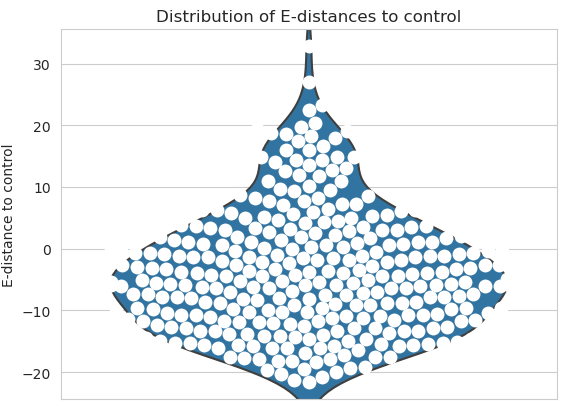

In [17]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['TuD_NC'], inner=None)
    sns.swarmplot(data=estats.loc['TuD_NC'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




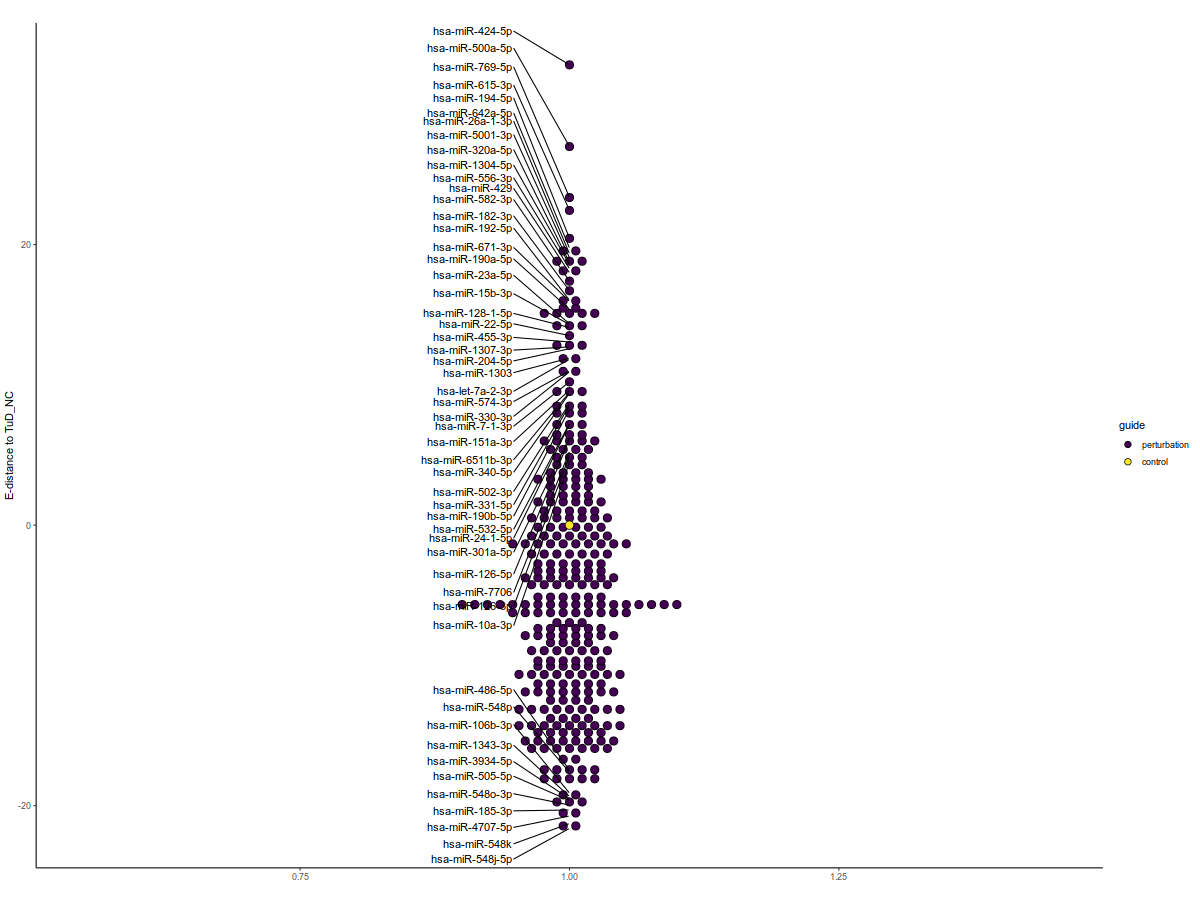

In [18]:
%%R -i estats -w 1200 -h 900
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(dplyr)

## draw barplots showing distances of the perturbations to each of the controls
## capture top 20% furthest guides from each of the controls


startsWith(colnames(estats), prefix = 'TuD') -> status
control_status = 1:length(status)
control_status[status] <- 'control'
control_status[!status] <- 'perturbation'
estats_control1 <- data.frame(comparison_to_control_NC1 = estats[,'TuD_NC'], guide = control_status, guide_nm = rownames(estats))
estats_control1 <- estats_control1[order(estats_control1$guide, decreasing = TRUE),]
estats_control1$guide <- factor(estats_control1$guide, levels = c('perturbation', 'control'))
tp20_pct <- as.character(estats_control1[order(estats_control1$comparison_to_control_NC1, decreasing = TRUE),"guide_nm"][1:ceiling(0.2*nrow(estats_control1))])
dotplot = ggplot(estats_control1, aes(x = 1, y=comparison_to_control_NC1, fill = guide)) + 
    geom_dotplot(binaxis='y', stackdir='center',
                 stackratio=1.5, dotsize=1.2, binwidth = 0.5) + scale_fill_viridis_d() + 
    geom_text_repel(aes(y = comparison_to_control_NC1, x = 1, label = guide_nm),
                    xlim = c(0, 0.95), 
                    direction = "y") +
    theme_classic() + ylab('E-distance to TuD_NC') + xlab('') + ggtitle('')

dotplot

Heatmap of pariwise E-distances of perturbations to each other

In [19]:
## in this heatmap a lighter color means a perturbation is further away from another perturbation
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100])
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_combined_controls_without_miR_families.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [20]:
## better color scheme
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100], cmap="vlag", vmin = -10, vmax = 10, cbar_kws={"ticks":[-10, -5,  0, 5,  10]})
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_color2_combined_controls_without_miR_families.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# E-testing (p-value calculation)

In [21]:
# e-testing (slow) -- here's what it's doing based on the paper:
## pvalue is found by combining the control cells and pertubation cells and switching their control/perturbation labels
## randomly 100 times to see how many times one gets a distance larger than when using the true original labels
## p-values are then adjusted using the Holm-Sidak method for multiple comparisons
df = etest(adata, obs_key='guide', obsm_key='X_pca', dist='sqeuclidean', control='TuD_NC', alpha=0.05, runs=100)

100%|██████████| 100/100 [13:55<00:00,  8.35s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [22]:
## convert all distances to z-scores,
## then find new pvalue_adj by summing the z


In [23]:
df.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_df_combined_controls_without_miR_families.csv')
df.sort_values('pvalue_adj')

edist  pvalue  significant  pvalue_adj  significant_adj
TuD_NC            0.000000    0.00         True    0.000000             True
hsa-miR-500a-5p  26.984652    0.03         True    0.999947            False
hsa-miR-769-5p   23.354818    0.05        False    1.000000            False
hsa-miR-615-3p   22.430086    0.05        False    1.000000            False
hsa-miR-424-5p   32.807153    0.06        False    1.000000            False
...                    ...     ...          ...         ...              ...
hsa-miR-200b-5p   1.444155    0.45        False    1.000000            False
hsa-miR-200a-5p   2.019179    0.36        False    1.000000            False
hsa-miR-200a-3p  -4.444034    0.63        False    1.000000            False
hsa-miR-331-3p   -7.773553    0.72        False    1.000000            False
hsa-miR-99b-5p   -4.947496    0.55        False    1.000000            False

[324 rows x 5 columns]

In [24]:
df.sort_values('pvalue')

edist  pvalue  significant  pvalue_adj  significant_adj
TuD_NC            0.000000    0.00         True    0.000000             True
hsa-miR-500a-5p  26.984652    0.03         True    0.999947            False
hsa-miR-769-5p   23.354818    0.05        False    1.000000            False
hsa-miR-615-3p   22.430086    0.05        False    1.000000            False
hsa-miR-424-5p   32.807153    0.06        False    1.000000            False
...                    ...     ...          ...         ...              ...
hsa-miR-548k    -21.269111    1.00        False    1.000000            False
hsa-miR-548j-5p -21.613652    1.00        False    1.000000            False
hsa-miR-185-3p  -20.306947    1.00        False    1.000000            False
hsa-miR-3934-5p -19.505731    1.00        False    1.000000            False
hsa-miR-505-5p  -19.638413    1.00        False    1.000000            False

[324 rows x 5 columns]

In [25]:
df.sort_values('pvalue').index[-1]

'hsa-miR-505-5p'

### Scatter plot of E-distance from control vs p-value

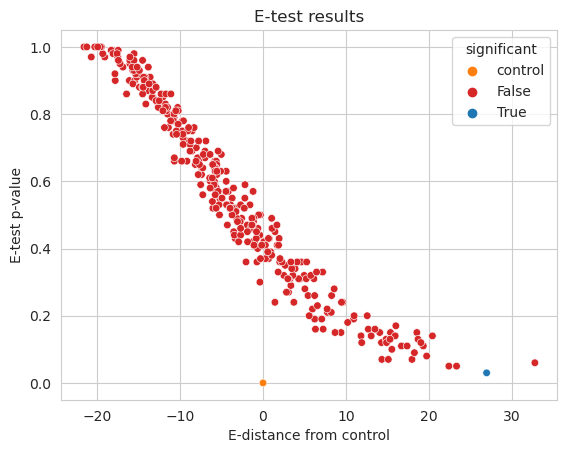

In [26]:
df.loc[df.index=='TuD_NC', 'significant'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue', x='edist', hue='significant', palette={True: 'tab:blue', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test p-value')
pl.show()

### Scatter plot of E-distance from control vs adjusted p-value

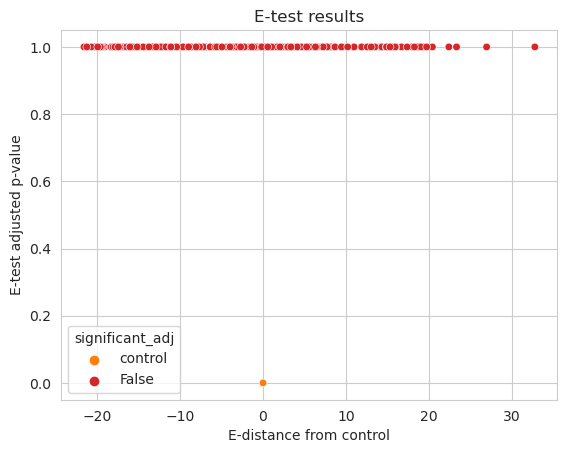

In [27]:
df.loc[df.index=='TuD_NC', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:blue', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

In [28]:
meta2 = sc.get.obs_df(adata, keys = adata.obs.columns.tolist())
meta2

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_2:TTCCGGTCAAGTGCAG-1        miR     30561.0          6252  miR_2   
miR_2:AAGCATCAGGAGAGGC-1        miR     26040.0          5676  miR_2   
miR_3:CCTTCAGCAAGTTCCA-1        miR     48031.0          7710  miR_3   
miR_2:TCACTATTCAATCAGC-1        miR     12131.0          3903  miR_2   
miR_1:TCACTCGCAAATACAG-1        miR     55856.0          7939  miR_1   
...                             ...         ...           ...    ...   
miR_3:ATACCTTGTAACAGTA-1        miR    103604.0          9812  miR_3   
miR_1:GCAACATGTAGTACGG-1        miR     55806.0          7906  miR_1   
miR_1:TCTTCCTAGACGGATC-1        miR     63381.0          8617  miR_1   
miR_1:GAAGTAACAAATGGAT-1        miR     32204.0          6274  miR_1   
miR_1:TGATCAGCACTGGCGT-1        miR     33970.0          5978  miR_1   

                                   barcode            guide       lor  \
miR_2:TTCCGGTCAAGTGCAG-1  TTCCGGTCAAGTGCAG           TuD_NC  3.894979   
miR_2:AAGCATCAGGAGAGGC-1  AAGCATCAGGAGAGGC           TuD_NC  5.145884   
miR_3:CCTTCAGCAAGTTCCA-1  CCTTCAGCAAGTTCCA           TuD_NC  0.771760   
miR_2:TCACTATTCAATCAGC-1  TCACTATTCAATCAGC           TuD_NC  0.987241   
miR_1:TCACTCGCAAATACAG-1  TCACTCGCAAATACAG           TuD_NC  2.706123   
...                                    ...              ...       ...   
miR_3:ATACCTTGTAACAGTA-1  ATACCTTGTAACAGTA  hsa-miR-301a-5p  2.527127   
miR_1:GCAACATGTAGTACGG-1  GCAACATGTAGTACGG  hsa-miR-301a-5p  2.933985   
miR_1:TCTTCCTAGACGGATC-1  TCTTCCTAGACGGATC  hsa-miR-301a-5p  6.478721   
miR_1:GAAGTAACAAATGGAT-1  GAAGTAACAAATGGAT  hsa-miR-301a-5p  6.377584   
miR_1:TGATCAGCACTGGCGT-1  TGATCAGCACTGGCGT  hsa-miR-301a-5p  1.830565   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_2:TTCCGGTCAAGTGCAG-1   1.444912e-45   1.503828e-38     43.0  ...   
miR_2:AAGCATCAGGAGAGGC-1  2.810142e-190  2.924727e-183     85.0  ...   
miR_3:CCTTCAGCAAGTTCCA-1   8.954815e-79   7.170559e-72     49.0  ...   
miR_2:TCACTATTCAATCAGC-1   4.426048e-29   4.606521e-22     26.0  ...   
miR_1:TCACTCGCAAATACAG-1   6.059599e-31   6.115671e-24     16.0  ...   
...                                 ...            ...      ...  ...   
miR_3:ATACCTTGTAACAGTA-1  4.940656e-324  3.956226e-317    253.0  ...   
miR_1:GCAACATGTAGTACGG-1  6.438111e-111  6.497685e-104     48.0  ...   
miR_1:TCTTCCTAGACGGATC-1  1.222639e-301  1.233952e-294    116.0  ...   
miR_1:GAAGTAACAAATGGAT-1  1.567584e-281  1.582090e-274    110.0  ...   
miR_1:TGATCAGCACTGGCGT-1   5.051413e-45   5.098156e-38     20.0  ...   

                             m_umi       v_umi  log_max_umi  log_n_umi  \
miR_2:TTCCGGTCAAGTGCAG-1  0.216625    4.740834     1.633468   1.934498   
miR_2:AAGCATCAGGAGAGGC-1  0.292191   18.303297     1.929419   2.064458   
miR_3:CCTTCAGCAAGTTCCA-1  0.375315    9.240096     1.690196   2.173186   
miR_2:TCACTATTCAATCAGC-1  0.128463    1.879920     1.414973   1.707570   
miR_1:TCACTCGCAAATACAG-1  0.093199    0.690787     1.204120   1.568202   
...                            ...         ...          ...        ...   
miR_3:ATACCTTGTAACAGTA-1  1.095718  166.495865     2.403121   2.638489   
miR_1:GCAACATGTAGTACGG-1  0.224181    6.295575     1.681241   1.949390   
miR_1:TCTTCCTAGACGGATC-1  0.345088   33.913442     2.064458   2.136721   
miR_1:GAAGTAACAAATGGAT-1  0.342569   30.503562     2.041393   2.133539   
miR_1:TGATCAGCACTGGCGT-1  0.125945    1.226522     1.301030   1.698970   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_2:TTCCGGTCAAGTGCAG-1  -0.664292    7.715716                       0   
miR_2:AAGCATCAGGAGAGGC-1  -0.534333    6.950845                       2   
miR_3:CCTTCAGCAAGTTCCA-1  -0.425604    5.875372                       5   
miR_2:TCACTATTCAATCAGC-1  -0.891220    7.468469                       0   
miR_1:TCACTCGCAAATACAG-1  -1.030589    4.275279                       1   
...                             ...         ...                     ...   
miR_

In [29]:
nn = pd.DataFrame(adata.obsm['X_umap'])

In [30]:
nn3 = pd.DataFrame(adata.obsm['X_pca'])

In [31]:
%%R -i meta2
far_guide_of_interest = 'hsa-miR-193a-5p'
far_guide <- rep('other_miR', nrow(meta2))
far_guide[which(meta2$guide == far_guide_of_interest)] <- far_guide_of_interest
far_guide[which(meta2$guide == 'TuD_NC')] <- 'control'

close_guide_of_interest = 'hsa-miR-128-1-5p'
close_guide <- rep('other_miR', nrow(meta2))
close_guide[which(meta2$guide == close_guide_of_interest)] <- close_guide_of_interest
close_guide[which(meta2$guide == 'TuD_NC')] <- 'control'

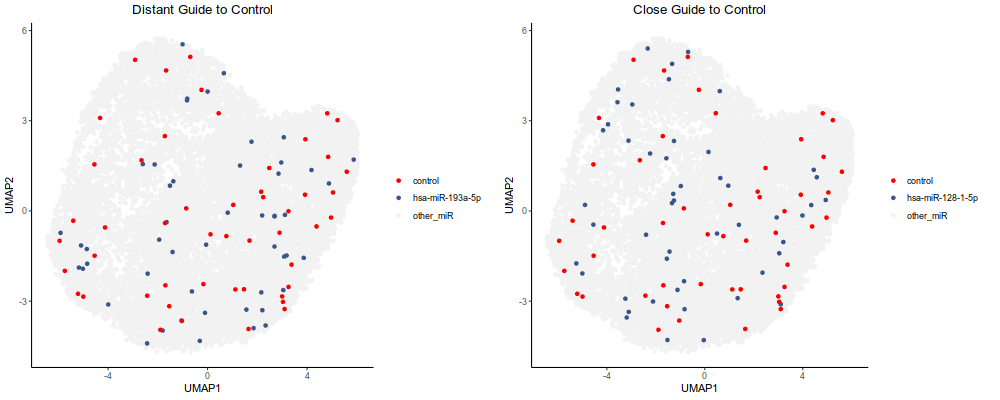

In [32]:
%%R -i nn -h 400 -w 1000

## showing the most distant pertubation to control
library(dplyr)
library(ggpubr)


nn2 = cbind(nn[,1:2], labs = far_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
a <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn2 = cbind(nn[,1:2], labs = close_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
b <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)

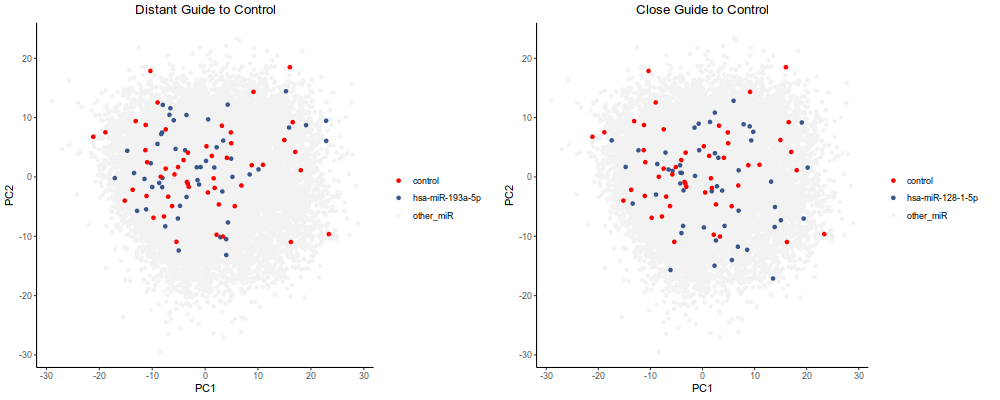

In [33]:
%%R -i nn3 -h 400 -w 1000
## showing the most distant pertubation to control

nn4 = cbind(nn3[,1:2], labs = far_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
a <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn4 = cbind(nn3[,1:2], labs = close_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
b <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)